# Basic Semantic Segmentation Demo


The following is a simple proof-of-concept demo showing how one can train a basic semantic segmentation model. Note that this demo is solely built to give an idea about the parts that we need in a semantic segmentation model.



- **Dataset:** [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/)

## Setup

### Download the Dataset and Set up the Environment

In [ ]:
%%shell
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2023-01-25 03:32:55--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  11.4MB/s    in 5.4s    

2023-01-25 03:33:03 (9.57 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2023-01-25 03:33:03--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-01-25 03:33:03--
Total wall clock time: 7.8s
Downloaded: 1 files, 51M in 5.4s (9.57 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
from torchvision import models, transforms
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches

## Dataset Loader

Below is a loader for the Penn-Fudan Database for Pedestrian Detection and Segmentation.

**Reference:** [Torchvision Object Detection Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        mask2 = Image.open(mask_path).convert("RGB")
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        masks = torch.sum(masks, dim=0)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)
            mask2 = self.transforms(mask2)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = mask2
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float)
])

dataset = PennFudanDataset('PennFudanPed', transform)
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
train_set = torch.utils.data.Subset(dataset, indices[:-50])
test_set = torch.utils.data.Subset(dataset, indices[-50:])
len(train_set), len(test_set)

(120, 50)

### Check Data Points

In [ ]:
X, y = next(iter(dataset))
X.shape, y

(torch.Size([3, 224, 224]), {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  'image_id': tensor

In [ ]:
def draw_mask(image, mask):
    # show
    img = transforms.ToPILImage()(image)
    height, width = img.size[0], img.size[1]
    fig, ax = plt.subplots(figsize=(15, 20))
    fig.set_facecolor('k')
    ax.imshow(img, alpha=0.5)
    ax.axis('off')
    plt.imshow(transforms.ToPILImage()(mask), alpha=0.5)

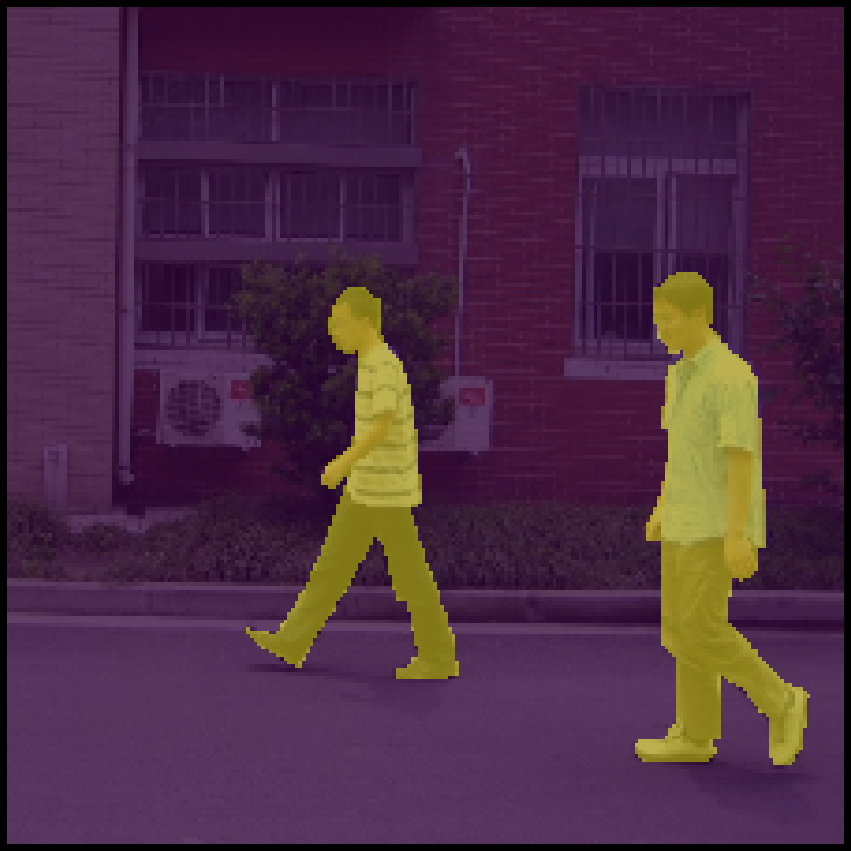

In [ ]:
draw_mask(X, 1.*(y['masks'][0,:,:]>0.))

## Segmentation Model

In [ ]:
class BasicSegmentor(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(3, channels[0], (7, 7), padding='same')
        self.layers = nn.ModuleList([nn.Sequential(
            nn.Conv2d(channels[i], channels[i + 1], (3, 3), padding='same'),
            nn.MaxPool2d((2, 2))
        ) for i in range(len(channels) - 1)])
        self.upsampling = nn.ModuleList([
            nn.ConvTranspose2d(channels[-1-i], channels[-2-i], (5, 5), stride=(2, 2))
            for i in range(len(channels) - 1)
        ])
        self.out = nn.Conv2d(channels[0], 1, (1, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        x = self.conv(X)
        for l in self.layers:
            x = l(x)
        for u in self.upsampling:
            x = u(x)
        x = self.out(x)
        return self.sigmoid(x[:, :, :X.shape[2], :X.shape[3]])

In [ ]:
segmentor = BasicSegmentor([32, 64, 128])
segmentor

BasicSegmentor(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upsampling): ModuleList(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2))
  )
  (out): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (sigmoid): Sigmoid()
)

In [ ]:
m = segmentor(X.unsqueeze(0)).squeeze().detach()
m.shape, X.shape

(torch.Size([224, 224]), torch.Size([3, 224, 224]))

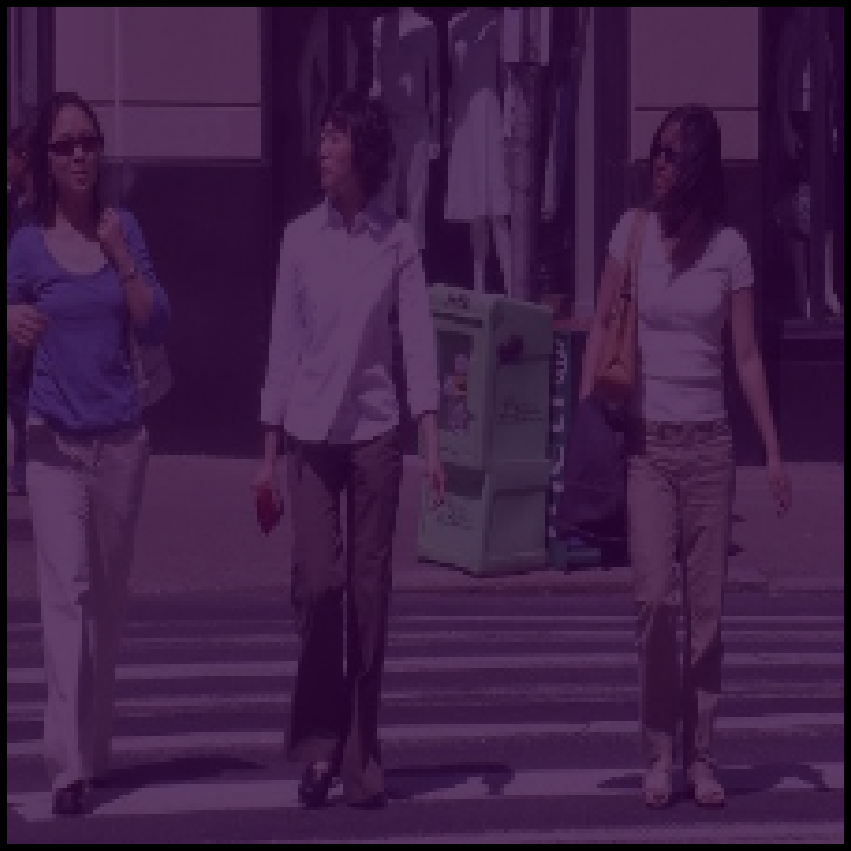

In [ ]:
draw_mask(X, 1.*(m>0.))

## Train

We train the network with BCE loss.

In [ ]:
device = torch.device('cuda:0')

In [ ]:
model = BasicSegmentor([32, 64, 128]).to(device)
loss = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 250
for e in range(epochs):
    print('Epoch {}/{}:'.format(e + 1, epochs), end=' ')
    model.train()
    train_loss = 0
    train = iter(train_set)
    for i, (X, y) in enumerate(train):
        y = (1.*(y['masks'][0,:,:]>0.)).to(device)
        preds = model(X.unsqueeze(0).to(device))
        l = loss(preds, y.float().resize_as_(preds))
        optim.zero_grad()
        l.backward()
        optim.step()
        train_loss += l

    with torch.no_grad():
        model.eval()
        test_loss = 0
        test = iter(test_set)
        for i, (X, y) in enumerate(test):
            y = (1.*(y['masks'][0,:,:]>0.)).to(device)
            preds = model(X.unsqueeze(0).to(device))
            l = loss(preds, y.float().resize_as_(preds))
            test_loss += l

    print('train loss {:.4f}, test loss {:.4f}'.format(train_loss, test_loss))

Epoch 1/250: train loss 58.8171, test loss 19.4895
Epoch 2/250: train loss 54.4776, test loss 19.5671
Epoch 3/250: train loss 53.7206, test loss 19.4371
Epoch 4/250: train loss 51.0583, test loss 18.3844
Epoch 5/250: train loss 48.3160, test loss 18.3315
Epoch 6/250: train loss 49.7294, test loss 18.1743
Epoch 7/250: train loss 46.9881, test loss 17.7765
Epoch 8/250: train loss 46.3267, test loss 17.4681
Epoch 9/250: train loss 46.7734, test loss 17.3275
Epoch 10/250: train loss 45.4976, test loss 17.2946
Epoch 11/250: train loss 44.1445, test loss 17.2477
Epoch 12/250: train loss 44.6201, test loss 16.8761
Epoch 13/250: train loss 44.3176, test loss 16.7041
Epoch 14/250: train loss 43.4097, test loss 16.5589
Epoch 15/250: train loss 44.1756, test loss 16.8237
Epoch 16/250: train loss 42.8438, test loss 16.3642
Epoch 17/250: train loss 42.6278, test loss 16.2745
Epoch 18/250: train loss 42.6363, test loss 16.2624
Epoch 19/250: train loss 42.3538, test loss 16.2222
Epoch 20/250: train l

## Test

### First, Let's Visualize the GT:

In [ ]:
dset_n = 16
for i in enumerate(iter(test_set)):
  if i[0] == dset_n:
    X, y = i[1]

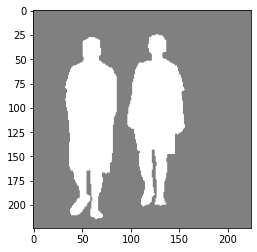

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.imshow(transforms.ToPILImage()(1.*(y['masks']>0.)), alpha=0.5)

### Now, Let's Visualize our Predictions:

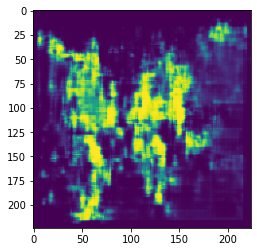

In [ ]:
model.eval()
preds = model(X.unsqueeze(0).to(device))
plt.imshow(preds.cpu().detach().numpy()[0,0,:,:])